# Patch Duration vs. Morphological Calls(63x) per Post Patch Outcomes

##### Date: 4/03/18 Updated 63x.csv, shiny.csv & patch_seq_log_mouse.csv

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import pg8000          #pg8000 access SQL databases
import pandas as pd    #pandas will be needed to work in a dataframe

from IPython.display import display #Found this to display all columns in a table

#Makes a white backround with gray horizontal gridmarks at y-values
sns.set_style('whitegrid')
sns.set_context('notebook')

#Context: paper
#Context: notebook
#Context: talk
#Context: poster

In [2]:
#Code from Agata
#Opens LIMS, makes a query and then closes LIMS after

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        #THESE ARE IMPORTANT!!!!!! (Every query needs to be closed when done)
        #This closes query
        cursor.close()             
        conn.close()
    return results


#This last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

##### postpatch_func.py by Rusty from Stash 

In [3]:
def nucleated(x):
    nuc_high_seal = x[(x['anno.postPatch_label'] == 'Nucleated') | 
                      (((x['anno.postPatch_label'] == 'nucleus_visible') | 
                      (x['anno.postPatch_label'] == 'nucleus_present')) & 
                      (x['anno.endPipetteR_label'] >= 500))]
    return nuc_high_seal

def partial_nucleated(y):
    nuc_low_seal = y[(y['anno.postPatch_label'] == 'Partial-Nucleus') | 
                     (((y['anno.postPatch_label'] == 'nucleus_present') | 
                     (y['anno.postPatch_label'] == 'nucleus_visible')) & 
                     (y["anno.endPipetteR_label"] <= 499))]
    return nuc_low_seal

def outside_out(z):
    no_nuc_high_seal = z[(z['anno.postPatch_label'] == 'Outside-Out') | 
                         (((z['anno.postPatch_label'] == 'nucleus_absent') | 
                         (z['anno.postPatch_label'] == 'no_nucleus_visible')) & 
                         (z['anno.endPipetteR_label'] >= 500))]
    return no_nuc_high_seal

def no_seal(w): 
    no_nuc_low_seal = w[(w['anno.postPatch_label'] == 'No-Seal') | 
                        (((w['anno.postPatch_label'] == 'nucleus_absent') | 
                        (w['anno.postPatch_label'] == 'no_nucleus_visible')) & 
                        (w['anno.endPipetteR_label'] <= 499))]
    return no_nuc_low_seal
    
def entire_cell(v):
    entire = v[(v['anno.postPatch_label'] == 'Entire-Cell') | 
               (v['anno.postPatch_label'] == 'entire_cell')]
    return entire

#variable['post patch class'] = 'Term'
#Term is an output displayed in the post patch class column

def reclassify(df):
    nu = nucleated(df)
    nu['post patch class'] = 'Nuc-high seal'      
    pn = partial_nucleated(df)
    pn['post patch class'] = 'Nuc-low seal'
    oo = outside_out(df)
    oo['post patch class'] = 'No nuc-high seal'
    ns = no_seal(df)
    ns['post patch class'] = 'No nuc-low seal'
    ec = entire_cell(df)
    ec['post patch class'] = 'Entire cell'
    return  nu, pn, oo, ns, ec

def concat_df(a, b, c, d, e):
    frames = (a, b, c, d, e)
    df = pd.concat(frames)
    return df

def postpatch_reclass(df):
    return concat_df(*reclassify(df))

#final_df = postpatch_reclass(final_df)

##### Reads 63x.csv, shiny.csv & patch_seq_log_mouse.csv

In [4]:
morph_df = pd.read_csv("63x.csv")
shiny_df = pd.read_csv("shiny.csv")
ps_df = pd.read_csv("patch_seq_log_mouse.csv")

##### Creating ps_df from patch_seq_log_mouse.csv

In [5]:
ps_initial = ['Lims tube id',
              'patch duration',
              'Time spent extracting cytosol',
              'Time spent retracting pipette']
ps_df = ps_df[ps_initial]
ps_df.head()

,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette
0,P1S4_170104_001_A01,11.78333333,2.3,NaN
1,P1S4_170104_002_A01,12.21666667,2.316666667,NaN
2,P1S4_170104_003_A01,11.78333333,2.45,NaN
3,P1S4_170104_004_A01,12.45,2.316666667,NaN
4,P1S4_170104_005_A01,12.36666667,2.35,NaN


##### Creating shiny_df from shiny.csv

In [6]:
shiny_initial = ['anno.sample_id',
                 'anno.postPatch_label',
                 'anno.endPipetteR_label']
shiny_df = shiny_df[shiny_initial]
shiny_df.head()

,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label
0,P1S4_160318_069_A01,O/O,0.0
1,P1S4_160407_108_A01,nucleated patch,0.0
2,P1S4_160407_109_A01,partial nucleus,0.0
3,P1S4_160407_112_A01,o/o,0.0
4,P1S4_160407_113_A01,0,0.0


##### Merging shiny_df with ps_df to create shiny_ps_df

In [7]:
#Left = shiny 
#Right = ps
#Inner merge = contains matched info between shiny and ps

shiny_ps_df = pd.merge(left = shiny_df, 
                         right = ps_df, 
                         left_on = 'anno.sample_id', 
                         right_on = 'Lims tube id', 
                         how = 'inner')

In [8]:
shiny_ps_df.head()

,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette
0,P2S4_170301_056_A01,0,0.0,P2S4_170301_056_A01,2.55,0.86666667,NaN
1,P2S4_170301_057_A01,0,0.0,P2S4_170301_057_A01,1.93333333,0.23333333,NaN
2,P2S4_170301_058_A01,0,0.0,P2S4_170301_058_A01,2.48333333,0.41666667,NaN
3,P1S4_170302_001_A01,0,0.0,P1S4_170302_001_A01,3.616666667,2.05,NaN
4,P1S4_170302_002_A01,0,0.0,P1S4_170302_002_A01,3.683333333,2.283333333,NaN


##### Creating morph_df from 63x.csv

In [9]:
morph_initial = ['patched_cell_container',
                 'ims63x_go_no_go',
                 'project']
morph_df = morph_df[morph_initial]
morph_df.tail()

,patched_cell_container,ims63x_go_no_go,project
6120,P2S4_180109_052_A01,NaN,mIVSCC-MET
6121,PAS4_180109_452_A01,NaN,mIVSCC-MET
6122,P8S4_180110_353_A01,NaN,mIVSCC-MET
6123,P8S4_180110_354_A01,63x no go,mIVSCC-MET
6124,PAS4_180110_454_A01,NaN,mIVSCC-MET


##### Merging morph_df with shiny_lims_df to create final_df

In [10]:
#Inner merge = contains only matching data of both morph_df and shiny_LIMS_df

final_df = pd.merge(left = morph_df, 
                    right = shiny_ps_df, 
                    left_on = 'patched_cell_container', 
                    right_on = 'anno.sample_id', 
                    how = 'inner')

In [11]:
final_df.head()

,patched_cell_container,ims63x_go_no_go,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette
0,P8S4_180103_351_A01,NaN,mIVSCC-MET,P8S4_180103_351_A01,nucleus_absent,35.0,P8S4_180103_351_A01,11.46666667,0.916666667,3.2
1,P8S4_180103_352_A01,63x no go,mIVSCC-MET,P8S4_180103_352_A01,nucleus_present,8.5,P8S4_180103_352_A01,10.16666667,1.7,2.5
2,P6S4_170609_253_A01,63x no go,T301x,P6S4_170609_253_A01,Partial-Nucleus,0.0,P6S4_170609_253_A01,5.83333333,2.16666667,NaN
3,P6S4_170609_254_A01,63x no go,T301x,P6S4_170609_254_A01,No-Seal,0.0,P6S4_170609_254_A01,5.78333333,2.08333333,NaN
4,P1S4_170609_001_A01,NaN,T301x,P1S4_170609_001_A01,No-Seal,0.0,P1S4_170609_001_A01,4.416666667,2.75,NaN


##### Creating Date column using patched_cell_container column

In [12]:
final_df['Date'] = final_df['patched_cell_container'].str[5:11]

In [13]:
final_df.tail()

,patched_cell_container,ims63x_go_no_go,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette,Date
2437,P2S4_180109_052_A01,NaN,mIVSCC-MET,P2S4_180109_052_A01,nucleus_present,1000.0,P2S4_180109_052_A01,16.68333333,0.683333333,1.933333333,180109
2438,PAS4_180109_452_A01,NaN,mIVSCC-MET,PAS4_180109_452_A01,nucleus_present,1500.0,PAS4_180109_452_A01,9.933333333,1.066666667,2.533333333,180109
2439,P8S4_180110_353_A01,NaN,mIVSCC-MET,P8S4_180110_353_A01,nucleus_absent,100.0,P8S4_180110_353_A01,11.85,0.85,3.133333333,180110
2440,P8S4_180110_354_A01,63x no go,mIVSCC-MET,P8S4_180110_354_A01,nucleus_present,1000.0,P8S4_180110_354_A01,11.2,0.616666667,2.433333333,180110
2441,PAS4_180110_454_A01,NaN,mIVSCC-MET,PAS4_180110_454_A01,nucleus_present,1000.0,PAS4_180110_454_A01,8.6,0.8,2.133333333,180110


##### Indexing Date column then sorting by date index

In [14]:
final_df = final_df.set_index('Date')
final_df = final_df.sort_index()

In [15]:
final_df.head()

,patched_cell_container,ims63x_go_no_go,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette
Date,,,,,,,,,,
170301,P2S4_170301_056_A01,NaN,T301x,P2S4_170301_056_A01,0,0.0,P2S4_170301_056_A01,2.55,0.86666667,NaN
170301,P2S4_170301_057_A01,NaN,T301x,P2S4_170301_057_A01,0,0.0,P2S4_170301_057_A01,1.93333333,0.23333333,NaN
170301,P2S4_170301_058_A01,NaN,T301x,P2S4_170301_058_A01,0,0.0,P2S4_170301_058_A01,2.48333333,0.41666667,NaN
170302,P1S4_170302_009_A01,NaN,T301x,P1S4_170302_009_A01,0,0.0,P1S4_170302_009_A01,2.833333333,1.566666667,NaN
170302,P2S4_170302_053_A01,NaN,T301x,P2S4_170302_053_A01,0,0.0,P2S4_170302_053_A01,3,1.65,NaN


In [16]:
final_df.tail()

,patched_cell_container,ims63x_go_no_go,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette
Date,,,,,,,,,,
180221,P8S4_180221_354_A01,NaN,mIVSCC-MET,P8S4_180221_354_A01,nucleus_present,1500.0,P8S4_180221_354_A01,11.43333333,1.166666667,4.066666667
180221,P8S4_180221_353_A01,NaN,mIVSCC-MET,P8S4_180221_353_A01,nucleus_present,100.0,P8S4_180221_353_A01,7.983333333,0.583333333,1.75
180221,P8S4_180221_352_A01,NaN,mIVSCC-MET,P8S4_180221_352_A01,nucleus_present,400.0,P8S4_180221_352_A01,7.233333333,0.516666667,2.133333333
180221,P8S4_180221_355_A01,NaN,mIVSCC-MET,P8S4_180221_355_A01,nucleus_absent,1000.0,P8S4_180221_355_A01,14.58333333,1.783333333,4.2
180221,PBS4_180221_506_A01,NaN,mIVSCC-MET,PBS4_180221_506_A01,nucleus_present,1000.0,PBS4_180221_506_A01,16.28333333,0.45,0.666666667


##### final_df start at production date to present date

In [17]:
final_df = final_df['170901':]

In [18]:
final_df.head()

,patched_cell_container,ims63x_go_no_go,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette
Date,,,,,,,,,,
170901,P8S4_170901_355_A01,63x go,T301x,P8S4_170901_355_A01,No-Seal,0.0,P8S4_170901_355_A01,9.86666667,0.68333333,NaN
170901,P2S4_170901_051_A01,63x go,T301x,P2S4_170901_051_A01,Nucleated,0.0,P2S4_170901_051_A01,9.96666667,0.85,NaN
170901,P2S4_170901_054_A01,63x go,T301x,P2S4_170901_054_A01,Partial-Nucleus,0.0,P2S4_170901_054_A01,12.2,1.03333333,NaN
170901,P8S4_170901_352_A01,63x no go,T301x,P8S4_170901_352_A01,Nucleated,0.0,P8S4_170901_352_A01,11.3166667,1.7,NaN
170901,P8S4_170901_351_A01,63x no go,T301x,P8S4_170901_351_A01,No-Seal,0.0,P8S4_170901_351_A01,11.6,0.98333333,NaN


In [19]:
final_df.tail()

,patched_cell_container,ims63x_go_no_go,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,patch duration,Time spent extracting cytosol,Time spent retracting pipette
Date,,,,,,,,,,
180221,P8S4_180221_354_A01,NaN,mIVSCC-MET,P8S4_180221_354_A01,nucleus_present,1500.0,P8S4_180221_354_A01,11.43333333,1.166666667,4.066666667
180221,P8S4_180221_353_A01,NaN,mIVSCC-MET,P8S4_180221_353_A01,nucleus_present,100.0,P8S4_180221_353_A01,7.983333333,0.583333333,1.75
180221,P8S4_180221_352_A01,NaN,mIVSCC-MET,P8S4_180221_352_A01,nucleus_present,400.0,P8S4_180221_352_A01,7.233333333,0.516666667,2.133333333
180221,P8S4_180221_355_A01,NaN,mIVSCC-MET,P8S4_180221_355_A01,nucleus_absent,1000.0,P8S4_180221_355_A01,14.58333333,1.783333333,4.2
180221,PBS4_180221_506_A01,NaN,mIVSCC-MET,PBS4_180221_506_A01,nucleus_present,1000.0,PBS4_180221_506_A01,16.28333333,0.45,0.666666667


##### Renaming Columns

In [20]:
#Duration columns are in seconds
final_df.rename(columns = {'ims63x_go_no_go' : 'Morphology',
                           'patch duration' : 'Patch Duration', 
                           'Time spent extracting cytosol' : 'Extraction Duration',
                           'Time spent retracting pipette' : 'Retraction Duration'}, inplace = True)

In [21]:
final_df.head()

,patched_cell_container,Morphology,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,Patch Duration,Extraction Duration,Retraction Duration
Date,,,,,,,,,,
170901,P8S4_170901_355_A01,63x go,T301x,P8S4_170901_355_A01,No-Seal,0.0,P8S4_170901_355_A01,9.86666667,0.68333333,NaN
170901,P2S4_170901_051_A01,63x go,T301x,P2S4_170901_051_A01,Nucleated,0.0,P2S4_170901_051_A01,9.96666667,0.85,NaN
170901,P2S4_170901_054_A01,63x go,T301x,P2S4_170901_054_A01,Partial-Nucleus,0.0,P2S4_170901_054_A01,12.2,1.03333333,NaN
170901,P8S4_170901_352_A01,63x no go,T301x,P8S4_170901_352_A01,Nucleated,0.0,P8S4_170901_352_A01,11.3166667,1.7,NaN
170901,P8S4_170901_351_A01,63x no go,T301x,P8S4_170901_351_A01,No-Seal,0.0,P8S4_170901_351_A01,11.6,0.98333333,NaN


In [22]:
final_df.tail()

,patched_cell_container,Morphology,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,Patch Duration,Extraction Duration,Retraction Duration
Date,,,,,,,,,,
180221,P8S4_180221_354_A01,NaN,mIVSCC-MET,P8S4_180221_354_A01,nucleus_present,1500.0,P8S4_180221_354_A01,11.43333333,1.166666667,4.066666667
180221,P8S4_180221_353_A01,NaN,mIVSCC-MET,P8S4_180221_353_A01,nucleus_present,100.0,P8S4_180221_353_A01,7.983333333,0.583333333,1.75
180221,P8S4_180221_352_A01,NaN,mIVSCC-MET,P8S4_180221_352_A01,nucleus_present,400.0,P8S4_180221_352_A01,7.233333333,0.516666667,2.133333333
180221,P8S4_180221_355_A01,NaN,mIVSCC-MET,P8S4_180221_355_A01,nucleus_absent,1000.0,P8S4_180221_355_A01,14.58333333,1.783333333,4.2
180221,PBS4_180221_506_A01,NaN,mIVSCC-MET,PBS4_180221_506_A01,nucleus_present,1000.0,PBS4_180221_506_A01,16.28333333,0.45,0.666666667


##### Adding post patch class column to the end of final_df

In [23]:
final_df = postpatch_reclass(final_df)
final_df.tail()

C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,patched_cell_container,Morphology,project,anno.sample_id,anno.postPatch_label,anno.endPipetteR_label,Lims tube id,Patch Duration,Extraction Duration,Retraction Duration,post patch class
Date,,,,,,,,,,,
180124,P9S4_180124_405_A01,NaN,mIVSCC-MET,P9S4_180124_405_A01,entire_cell,4.0,P9S4_180124_405_A01,16.11666667,0.783333333,8.216666667,Entire cell
180126,P9S4_180126_404_A01,NaN,mIVSCC-MET,P9S4_180126_404_A01,entire_cell,11.5,P9S4_180126_404_A01,11.45,0.633333333,1.883333333,Entire cell
180205,P1S4_180205_003_A01,63x no go,mIVSCC-MET,P1S4_180205_003_A01,entire_cell,5.0,P1S4_180205_003_A01,5.983333333,0.566666667,1.216666667,Entire cell
180207,P1S4_180207_003_A01,NaN,mIVSCC-MET,P1S4_180207_003_A01,entire_cell,3.0,P1S4_180207_003_A01,4.816666667,0.433333333,0.933333333,Entire cell
180220,PAS4_180220_451_A01,NaN,mIVSCC-MET,PAS4_180220_451_A01,entire_cell,5.7,PAS4_180220_451_A01,8.633333333,1.6,0.533333333,Entire cell


##### Dropping columns 

In [24]:
final_df.drop(['patched_cell_container', 'project', 'anno.sample_id', 'Lims tube id'], axis=1, inplace=True)
final_df.head()

,Morphology,anno.postPatch_label,anno.endPipetteR_label,Patch Duration,Extraction Duration,Retraction Duration,post patch class
Date,,,,,,,
170901,63x go,Nucleated,0.0,9.96666667,0.85,NaN,Nuc-high seal
170901,63x no go,Nucleated,0.0,11.3166667,1.7,NaN,Nuc-high seal
170901,NaN,Nucleated,0.0,9.4,0.7,NaN,Nuc-high seal
170901,63x go,Nucleated,0.0,10.45,1.3,NaN,Nuc-high seal
170906,63x go,Nucleated,0.0,6.8,2.11666667,NaN,Nuc-high seal


In [25]:
final_df.tail()

,Morphology,anno.postPatch_label,anno.endPipetteR_label,Patch Duration,Extraction Duration,Retraction Duration,post patch class
Date,,,,,,,
180124,NaN,entire_cell,4.0,16.11666667,0.783333333,8.216666667,Entire cell
180126,NaN,entire_cell,11.5,11.45,0.633333333,1.883333333,Entire cell
180205,63x no go,entire_cell,5.0,5.983333333,0.566666667,1.216666667,Entire cell
180207,NaN,entire_cell,3.0,4.816666667,0.433333333,0.933333333,Entire cell
180220,NaN,entire_cell,5.7,8.633333333,1.6,0.533333333,Entire cell


##### Filters columns that have NaN

In [26]:
final_df.dropna(subset = ['Morphology', 'anno.endPipetteR_label', 'Patch Duration'], inplace = True)

In [27]:
final_df.head()

,Morphology,anno.postPatch_label,anno.endPipetteR_label,Patch Duration,Extraction Duration,Retraction Duration,post patch class
Date,,,,,,,
170901,63x go,Nucleated,0.0,9.96666667,0.85,NaN,Nuc-high seal
170901,63x no go,Nucleated,0.0,11.3166667,1.7,NaN,Nuc-high seal
170901,63x go,Nucleated,0.0,10.45,1.3,NaN,Nuc-high seal
170906,63x go,Nucleated,0.0,6.8,2.11666667,NaN,Nuc-high seal
170906,63x no go,Nucleated,0.0,6.2,0.96666667,NaN,Nuc-high seal


In [28]:
final_df.tail()

,Morphology,anno.postPatch_label,anno.endPipetteR_label,Patch Duration,Extraction Duration,Retraction Duration,post patch class
Date,,,,,,,
171101,63x no go,entire_cell,3.5,8.23333333,0.35,1.35,Entire cell
171102,63x go,entire_cell,200.0,8.35,1.61666667,1.21666667,Entire cell
171116,63x go,entire_cell,1000.0,4.58333333,0.46666667,0,Entire cell
171211,63x no go,entire_cell,2000.0,12.3,1.183333333,2.2,Entire cell
180205,63x no go,entire_cell,5.0,5.983333333,0.566666667,1.216666667,Entire cell


In [29]:
#Categorical
final_df['Morphology'] = final_df['Morphology'].astype('category')
final_df['post patch class'] = final_df['post patch class'].astype('category')

#Numerical
#final_df['anno.endPipetteR_label'] = final_df['anno.endPipetteR_label'].astype('float')
final_df['Patch Duration'] = final_df['Patch Duration'].astype('float')
final_df['Extraction Duration'] = final_df['Extraction Duration'].astype('float')
#final_df['Retraction Duration'] = final_df['Retraction Duration'].astype('float')

In [30]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873 entries, 170901 to 180205
Data columns (total 7 columns):
Morphology                873 non-null category
anno.postPatch_label      873 non-null object
anno.endPipetteR_label    873 non-null float64
Patch Duration            873 non-null float64
Extraction Duration       873 non-null float64
Retraction Duration       707 non-null object
post patch class          873 non-null category
dtypes: category(2), float64(3), object(2)
memory usage: 42.9+ KB


##### Box Plot of Patch Duration vs Morphology(63x)

Text(0,0.5,u'Patch Duration (min)')

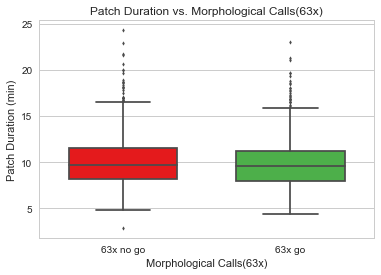

In [31]:
sns.boxplot(x = "Morphology", 
            y = "Patch Duration", 
            data = final_df[final_df['Patch Duration'] > 1],
            order = ["63x no go","63x go"],
            palette = ['#e41a1c', '#4daf4a'],
            width = 0.65,
            saturation = 1,
            fliersize = 3).set_title("Patch Duration vs. Morphological Calls(63x)")
plt.xlabel("Morphological Calls(63x)")
plt.ylabel("Patch Duration (min)")
#plt.savefig("box_patch_duration_vs_morph")

##### Box Plot of Patch Duration vs Post Patch Outcomes

Text(0,0.5,u'Patch Duration (min)')

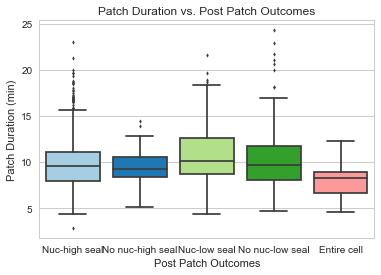

In [32]:
sns.boxplot(x = "post patch class", 
            y = "Patch Duration", 
            order = ['Nuc-high seal', 'No nuc-high seal', 'Nuc-low seal', 'No nuc-low seal', 'Entire cell'],
            data = final_df[final_df['Patch Duration'] > 1],
            palette = 'Paired',
            saturation = 1,
            fliersize = 3).set_title("Patch Duration vs. Post Patch Outcomes")

plt.xlabel("Post Patch Outcomes")
plt.ylabel("Patch Duration (min)")
#plt.savefig("box_patch_duration_vs_morph")

##### Box Plot of Patch Duration vs Morphological Calls per Post Post Outcomes

Text(0,0.5,u'Patch Duration (min)')

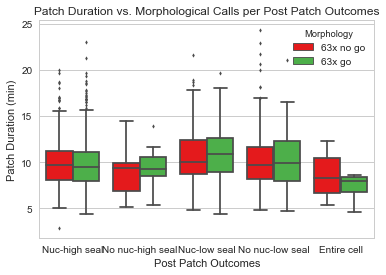

In [33]:
sns.boxplot(x = "post patch class", 
            y = "Patch Duration", 
            hue = "Morphology",
            order = ['Nuc-high seal', 'No nuc-high seal', 'Nuc-low seal', 'No nuc-low seal', 'Entire cell'],
            hue_order = ["63x no go","63x go"],
            data = final_df[final_df['Patch Duration'] > 1],
            palette = ["#e41a1c", "#4daf4a"], 
            saturation = 1,
            fliersize = 3).set_title("Patch Duration vs. Morphological Calls per Post Patch Outcomes")
plt.xlabel("Post Patch Outcomes")
plt.ylabel("Patch Duration (min)")
#plt.legend(loc = "upper right")
#plt.savefig("box_patch_duration_vs_morph_user")

## Extra Plots

In [34]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873 entries, 170901 to 180205
Data columns (total 7 columns):
Morphology                873 non-null category
anno.postPatch_label      873 non-null object
anno.endPipetteR_label    873 non-null float64
Patch Duration            873 non-null float64
Extraction Duration       873 non-null float64
Retraction Duration       707 non-null object
post patch class          873 non-null category
dtypes: category(2), float64(3), object(2)
memory usage: 42.9+ KB


In [35]:
final_df.reset_index(inplace = True)
final_df.head()

,Date,Morphology,anno.postPatch_label,anno.endPipetteR_label,Patch Duration,Extraction Duration,Retraction Duration,post patch class
0,170901,63x go,Nucleated,0.0,9.966667,0.850000,NaN,Nuc-high seal
1,170901,63x no go,Nucleated,0.0,11.316667,1.700000,NaN,Nuc-high seal
2,170901,63x go,Nucleated,0.0,10.450000,1.300000,NaN,Nuc-high seal
3,170906,63x go,Nucleated,0.0,6.800000,2.116667,NaN,Nuc-high seal
4,170906,63x no go,Nucleated,0.0,6.200000,0.966667,NaN,Nuc-high seal
